In [114]:
from tqdm import tqdm, tqdm_notebook
from mxnet import np, npx
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import mxnet.gluon.probability as mgp
from mxnet.gluon.probability import StochasticBlock, StochasticSequential
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage, misc

npx.set_np()
data_ctx = mx.cpu()
model_ctx = mx.gpu(2)

In [115]:
def load_data(batch_size):
    """
    Load MNIST
    """
    mnist_train = gluon.data.vision.MNIST(train=True)
    mnist_test = gluon.data.vision.MNIST(train=False)
    num_worker = 4
    transformer = gluon.data.vision.transforms.ToTensor()
    return (gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                batch_size, shuffle=True,
                                num_workers=num_worker),
          gluon.data.DataLoader(mnist_test.transform_first(transformer),
                                batch_size, shuffle=False,
                                num_workers=num_worker))

Construct A Bayesian dense layer using local reparameterization trick

In [116]:
class LocalReparamDense(StochasticBlock):
    def __init__(self, in_features, out_features, activation=None, flatten=True, dtype='float32'):
        super(LocalReparamDense, self).__init__()
        self._flatten = flatten
        self.qw_x = None
        self._in_features = in_features
        self._out_features = out_features
        # Parameter of weight
        self.loc_w = gluon.Parameter('loc_w', shape=(out_features, in_features),
                                    dtype=dtype)
        self.scale_w = gluon.Parameter('log_scale_w', shape=(out_features, in_features),
                                    dtype=dtype)
        # Parameter of bias
        self.bias = gluon.Parameter('bias', shape=(out_features,),
                                    dtype=dtype)
        if activation is not None:
            self.act = gluon.nn.Activation(activation)
        else:
            self.act = None

    @StochasticBlock.collectLoss
    def hybrid_forward(self, F, x, loc_w, scale_w, bias):
        # We use `fc` operator for matrix multiplication.
        fc = F.npx.fully_connected
        # Directly acquire parameter for A = dot(x, W)
        # with local reparameterization trick:
        qa_loc = fc(x, loc_w, bias=None, no_bias=True, num_hidden=self._out_features,
                    flatten=self._flatten)
        qa_scale = F.np.sqrt(fc(x ** 2, scale_w ** 2, bias=None, no_bias=True,
                      num_hidden=self._out_features, flatten=self._flatten))
        self.qw_x = mgp.Normal(
            loc=qa_loc,
            scale=qa_scale
        )
        # KL(qw_x || px), where px ~ N(0, 1)
        kl = mgp.kl_divergence(self.qw_x, mgp.Normal(0, 1)).sum(-1)
        self.add_loss(kl)
        # Sampling from the network
        fc_samples = self.qw_x.sample() + bias
        if self.act is not None:
            out = self.act(fc_samples)
        else:
            out = fc_samples
        return out

## MNIST classfication with BNN

In [117]:
def train(net, n_epoch, train_iter, test_iter, baseline=False):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                      {'learning_rate': .001})
    training_loss = []
    validation_loss = []
    loss_func = gluon.loss.SoftmaxCrossEntropyLoss(from_logits=(not baseline))
    metric = mx.gluon.metric.Accuracy()
    for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
        epoch_loss = 0
        metric.reset()
        for batch in train_iter:
            data = batch[0].as_in_context(model_ctx).reshape(-1, 28 * 28)
            label = batch[1].as_in_context(model_ctx)
            kl_loss = 0
            with autograd.record():
                logits = net(data)
                classification_loss = loss_func(logits, label)
                # `baseline` model stands for deterministic MLP
                if baseline:
                    loss = classification_loss
                else:
                    for layer_kl_loss in net.losses:
                        kl_loss = kl_loss + layer_kl_loss[0]
                    loss = classification_loss + kl_loss / data.shape[0]
            loss.backward()
            trainer.step(data.shape[0])
            epoch_loss += np.mean(classification_loss)
        print(epoch_loss)
        test_loss = 0
        for batch in test_iter:
            data = batch[0].as_in_context(model_ctx).reshape(-1, 28 * 28)
            label = batch[1].as_in_context(model_ctx)
            logits = net(data)
            classification_loss = loss_func(logits, label)
            test_loss += np.mean(classification_loss)
            metric.update([label], [logits.as_nd_ndarray()])
        name, acc = metric.get()
        print('[Epoch %d] Training: %s=%f'%(epoch, name, acc))

        

In [ ]:
mlp = nn.HybridSequential()
mlp.add(nn.Dense(256, activation='relu'))
mlp.add(nn.Dense(256, activation='relu'))
mlp.add(nn.Dense(10))
mlp.initialize(ctx=model_ctx)
mlp.hybridize()

In [118]:
batch_size = 256
train_set, test_set = load_data(batch_size)
train(
    net=mlp,
    n_epoch=10,
    train_iter=train_set,
    test_iter=test_set,
    baseline=True)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


34.827023
[Epoch 0] Training: accuracy=0.964000
21.93256
[Epoch 1] Training: accuracy=0.968900
15.188565
[Epoch 2] Training: accuracy=0.975600
11.173554
[Epoch 3] Training: accuracy=0.977900
8.552803
[Epoch 4] Training: accuracy=0.978600
6.547309
[Epoch 5] Training: accuracy=0.978800
5.0682487
[Epoch 6] Training: accuracy=0.980500
4.151696
[Epoch 7] Training: accuracy=0.979000
3.3864
[Epoch 8] Training: accuracy=0.978000
2.2683651
[Epoch 9] Training: accuracy=0.980400



In [119]:
bnn = StochasticSequential()
bnn.add(LocalReparamDense(784, 256, activation='relu'))
bnn.add(LocalReparamDense(256, 256, activation='relu'))
bnn.add(LocalReparamDense(256, 10))
bnn.initialize(ctx=model_ctx)
bnn.hybridize()

In [120]:
batch_size = 256
train_set, test_set = load_data(batch_size)
train(
    net=bnn,
    n_epoch=10,
    train_iter=train_set,
    test_iter=test_set,
    baseline=False)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


-21566.24
[Epoch 0] Training: accuracy=0.913800
-43505.67
[Epoch 1] Training: accuracy=0.942200
-48185.86
[Epoch 2] Training: accuracy=0.956500
-50476.934
[Epoch 3] Training: accuracy=0.962200
-51843.543
[Epoch 4] Training: accuracy=0.968400
-52813.168
[Epoch 5] Training: accuracy=0.971200
-53621.207
[Epoch 6] Training: accuracy=0.973500
-54159.46
[Epoch 7] Training: accuracy=0.974400
-54665.188
[Epoch 8] Training: accuracy=0.974300
-54995.125
[Epoch 9] Training: accuracy=0.976100



Next, we perform classfication on white noise to demonstrate the advantages of a Bayesian neural network.

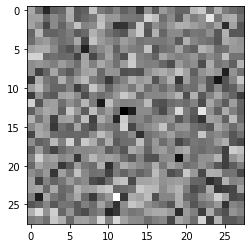

In [121]:
# Generate random noise
x = np.random.randn(28, 28)
plt.imshow(x.asnumpy(), cmap='gray')

In [122]:
num_samples = 100
bnn_prediction = npx.softmax(bnn(np.repeat(np.expand_dims(x, 0), 100, 0).as_in_context(model_ctx))).mean(0).asnumpy()
mlp_prediction = npx.softmax(mlp(np.repeat(np.expand_dims(x, 0), 100, 0).as_in_context(model_ctx))).mean(0).asnumpy()

In [124]:
mlp_prediction

array([8.2485174e-04, 2.4049863e-02, 2.1247934e-03, 1.1910000e-05,
       2.3079795e-18, 4.9061771e-03, 6.3542284e-02, 9.0454000e-01,
       1.5122880e-07, 1.1579371e-12], dtype=float32)

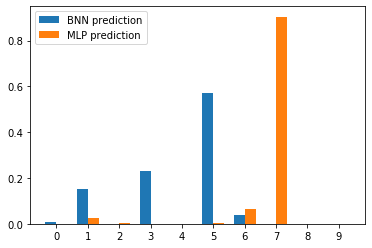

In [123]:
labels = [str(i) for i in range(10)]
x = np.arange(len(labels)).asnumpy()  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bnn_prediction, width, label='BNN prediction')
rects2 = ax.bar(x + width/2, mlp_prediction, width, label='MLP prediction')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()